<a href="https://colab.research.google.com/github/daniela-estevez/ProyectoIntegrador/blob/main/Avance4_13Equipo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avance 4. Modelos alternativos

## Equipo 13

## Alejandro García Hernández A01793812
## Daniela Estevez Rodriguez A01793723
## Carlos Alberto López Álvarez A01168193

## Objetivos

En esta etapa el objetivo es construir múltiples modelos con lafinalidad de explorar y evaluar cuál de ellos proporciona el mejor rendimiento para resolver el problema que nos fue asignado. El ejercicio se centra en la elección de los modelos, su entrenamiento y configuración de hiperparámetros para mejorar el desempeño.

## 0. Librerías

In [78]:
import warnings
warnings.filterwarnings("ignore")

In [79]:
# Librerías a utilizar para el pre procesamiento.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder

In [80]:
# Librerías para la sección de modelos supervisados
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix,f1_score, accuracy_score, classification_report, recall_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import display
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder

In [81]:
# Librerías adicionales para la sección de modelos no-supervisados
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import fcluster, linkage

In [82]:
# El siguiente bloque se agregó para poder leer los archivos drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Proyecto Integrador

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Proyecto Integrador


## 1. Preparación de datos

Se aplica el pre procesamiento de los datos que se ha trabajado en semanas anteriores

In [83]:
data = pd.read_csv("base.csv",sep=",", encoding="latin1")
df= data.copy()

In [84]:
# Eliminamos entonces estas características
df = df.drop(["Nombre","residencia","fecha_nacimiento","fecha_1er_visita","FECHA_INICIO_ACTUAL_EPISODIO"], axis=1)
df = df.dropna(axis=1, how='all')

In [85]:
# Calculamos el porcentaje de valores nulos en cada columna
null_percentage = (df.isnull().sum() / len(df)) * 100

# Con el sguiente código, se crea un DataFrame con los porcentajes de valores nulos
null_df = pd.DataFrame({'Columna': null_percentage.index, 'Porcentaje_Null': null_percentage.values})

# Filtramos el DataFrame para mantener solo las columnas donde el porcentaje de valores nulos sea menor al 40%
columnas_a_mantener = null_df[null_df['Porcentaje_Null'] < 40]['Columna']

# Filtramos el DataFrame original para mantener solo las columnas que queremos conservar
df = df[columnas_a_mantener]

In [86]:
#Primero obtenemos las variables que reportan un solo valor y mostramos sus nombres
unique_counts = df.nunique()
columnas_a_eliminar = unique_counts[unique_counts == 1].index
columnas_a_eliminar
df = df.drop(columns=columnas_a_eliminar)

In [87]:
binary_columns = []
for column in df.columns:
    unique_values = df[column].unique()
    if len(unique_values) == 2 and all(value in [0, 1] for value in unique_values):
        binary_columns.append(column)

# Número de columnas con solamente 0's o 1's
print("Numero de columnas binarias encontradas:", len(binary_columns))

Numero de columnas binarias encontradas: 28


In [88]:
# Actualizamos el tipo de las columnas binarias a booleano usando astype()
for column in binary_columns:
    df[column] = df[column].astype(bool)

In [89]:
# Lista de variables que son en realidad categóricas
cat_cols=["SEXO","CONDICION_ACTUAL","ESTADO_civil","RELIGION","PROVEEDOR_FAMILIAR","OCUPACIoN_JEFE_FAMILIA","ESCOLARIDAD__JEFE_FAMILIA",
         "ESCOLARIDAD_MAXIMA_PX","DX_PRIMARIO","CODIGO_DX.1","TRASTORNO_MAYOR_DIAGNOSTICO",
         "Riesgo_suicidio","Sintomas_ansiosos"]

# Actualizamos el tipo de las columnas categoricas usando astype()
for column in cat_cols:
    df[column] = df[column].astype("category")

In [90]:
# Actualizamos el tipo de la columna MENARCA a uno numérico usando astype()
df["MENARCA"] = df["MENARCA"].astype("float64")

In [91]:
# Sustituir los valores de MENARCA donde SEXO es "M"
df.loc[df['SEXO'] == 'M', 'MENARCA'] = -1

# Imputar la moda a las variables numéricas
for columna in df.select_dtypes(include='number').columns:
    df[columna] = df[columna].fillna(df[columna].median())

# Imputar la moda a las variables booleanas
for columna in df.select_dtypes(include='bool').columns:
    moda = df[columna].mode()[0]  # Calcular la moda
    df[columna] = df[columna].fillna(moda)

# Imputar la moda a las variables alfanuméricas
for columna in df.select_dtypes(include='category').columns:
    moda = df[columna].mode()[0]  # Calcular la moda
    df[columna] = df[columna].fillna(moda)

In [92]:
# Lista de variables que son en realidad enteros
enteros_cols=["EDAD_1era_visita","EDAD_INICIO_1er_EPISODIO","AnioS_ESTUDIO_PACIENTE","MENARCA","INICIO_VIDA_SEXUAL_ACTIVA","MADRS_TOTAL","CGI-S.1"]

# Actualizamos el tipo de las columnas de enteros usando astype()
for column in enteros_cols:
    df[column] = df[column].astype("int64")

In [93]:
# Eliminamos estas características
df = df.drop(["EPISODIO_MAYOR_total_vida","SUICIDALIDAD_ACTUAL","SUICIDALIDAD_INTENTO_total_vida",
              "B1b_INTENCION_DE_MORIR_EN_ACCIDENTE","B5_PENSO_METODO_SUICIDARSE","B8_PENSO_FECHA_SUICIDIO",
              "B10_INTENCION_SUICIDIO","B18_INTENTO_SUICIDARSE","B2_NECESIDAD_DE_ESTAR_MUERTO","TRASTORNO_MAYOR_PASADO"],
             axis=1)

In [94]:
# Eliminamos estas características
df = df.drop(["CODIGO_DX.1","Puntaje_experto"],
             axis=1)

In [95]:
# Reemplazar el valor 1955 por la mediana
df['EDAD_INICIO_1er_EPISODIO'] = df['EDAD_INICIO_1er_EPISODIO'].replace(1955, df['EDAD_INICIO_1er_EPISODIO'].median())

# Reemplazar el valor 1 por la mediana
df['INICIO_VIDA_SEXUAL_ACTIVA'] = df['INICIO_VIDA_SEXUAL_ACTIVA'].replace(1, df['INICIO_VIDA_SEXUAL_ACTIVA'].median())

In [96]:
# Realizamos una copia del df para realizar una trasnformación
df_T=df.copy()

**Winsonorización:** Reemplaza los valores atípicos con valores en el percentil p-ésimo o (1 - p)-ésimo para reducir su impacto sin eliminarlos.

In [97]:
# Transformamos las variables usando Winsonorización
df_T['INICIO_VIDA_SEXUAL_ACTIVA_W'] = winsorize(df_T['INICIO_VIDA_SEXUAL_ACTIVA'], limits=(0.05, 0.05))
df_T['DURACION_EPISODIO_MAYOR_ACTUAL_W'] = winsorize(df_T['DURACION_EPISODIO_MAYOR_ACTUAL'], limits=(0.05, 0.05))

In [98]:
# Eliminamos estas características originales
df_T = df_T.drop(["INICIO_VIDA_SEXUAL_ACTIVA","DURACION_EPISODIO_MAYOR_ACTUAL"],
             axis=1)

In [99]:
# Hacemos listas de las variables ordinales
cat_orginales= ['ESCOLARIDAD__JEFE_FAMILIA', 'ESCOLARIDAD_MAXIMA_PX', 'DX_PRIMARIO','TRASTORNO_MAYOR_DIAGNOSTICO',
                'Riesgo_suicidio','Sintomas_ansiosos']

In [100]:
# Creamos una copia del dataframe
df_TC=df_T.copy()

In [101]:
# Crear el encoder ordinal
encoder_1 = OrdinalEncoder(categories=[["Menos de 6 años", "Primaria", "Secundaria", "Preparatoria",
                                     "Estudios universitarios no terminados", "Licenciatura", "Posgrado"]], dtype=int)
encoder_2 = OrdinalEncoder(categories=[["Distimia","Trastorno depresivo episodio único ",
                                        "Trastorno depresivo mayor recidivante"]], dtype=int)
encoder_3 = OrdinalEncoder(categories=[["0","TRASTORNO DEPRESIVO MAYOR EPISODIO UNICO",
                                        "TRASTORNO DEPRESIVO MAYOR PRIMER EPISODIO",
                                        "TRASTORNO DEPRESIVO MAYOR RECURRENTE",
                                        "TRASTORNO DEPRESIVO MAYOR RECIDIVANTE ",
                                        "TRASTORNO DEPRESIVO MAYOR RECURRENTE RESISTENTE",
                                        "TRASTORNO DEPRESIVO MAYOR RECURRENTE SEVERO",
                                        "TRASTORNO DEPRESIVO MAYOR"]], dtype=int)
encoder_4 = OrdinalEncoder(categories=[["Leve","Moderado","Alto"]], dtype=int)
encoder_5 = OrdinalEncoder(categories=[["Leve","Moderado-Grave"]], dtype=int)
encoder_6 = OrdinalEncoder(categories=[["Primera aparición sin antecedente","Indistinguible del pasado",
                                        "Recurrencia condición previa",
                                        "Significativamente diferente de condición previa",
                                        "Exageración de trastorno crónico"]], dtype=int)

# Ajustar y transformar los datos
df_TC['ESCOLARIDAD__JEFE_FAMILIA_encoded'] = encoder_1.fit_transform(df_TC[['ESCOLARIDAD__JEFE_FAMILIA']])
df_TC['ESCOLARIDAD_MAXIMA_PX_encoded'] = encoder_1.fit_transform(df_TC[['ESCOLARIDAD_MAXIMA_PX']])
df_TC['DX_PRIMARIO_encoded'] = encoder_2.fit_transform(df_TC[['DX_PRIMARIO']])
df_TC['TRASTORNO_MAYOR_DIAGNOSTICO_encoded'] = encoder_3.fit_transform(df_TC[['TRASTORNO_MAYOR_DIAGNOSTICO']])
df_TC['Riesgo_suicidio_encoded'] = encoder_4.fit_transform(df_TC[['Riesgo_suicidio']])
df_TC['Sintomas_ansiosos_encoded'] = encoder_5.fit_transform(df_TC[['Sintomas_ansiosos']])
df_TC['CONDICION_ACTUAL_encoded'] = encoder_6.fit_transform(df_TC[['CONDICION_ACTUAL']])

In [102]:
# Eliminamos estas características originales
df_TC = df_TC.drop(["ESCOLARIDAD__JEFE_FAMILIA","ESCOLARIDAD_MAXIMA_PX","DX_PRIMARIO","TRASTORNO_MAYOR_DIAGNOSTICO",
                "Riesgo_suicidio","Sintomas_ansiosos","CONDICION_ACTUAL"],
             axis=1)

In [103]:
# Hacemos listas de las variables no ordinales
cat_no_orginales= ['SEXO', 'ESTADO_civil', 'RELIGION','PROVEEDOR_FAMILIAR', 'OCUPACIoN_JEFE_FAMILIA']

In [104]:
# Creamos una copia del ultimo dataframe
df_TCL=df_TC.copy()

In [105]:
# Inicializar el LabelEncoder
encoder = LabelEncoder()

# Iterar sobre las columnas y aplicar el LabelEncoder
for col in cat_no_orginales:
    df_TCL[col] = encoder.fit_transform(df_TCL[col])

In [106]:
# Creamos una copia del ultimo dataframe
df_TC_encoded=df_TC.copy()

In [107]:
# Aplicar Get_dummies asegurando de eliminar la primera categoría
df_TC_encoded = pd.get_dummies(df_TC_encoded, columns=cat_no_orginales, drop_first=True)

## 2 Modelos supervisados

Comanzaremos con una observación importante, el proyecto con el que estamos trabajando tiene que ver con la salud mental y física de pacientes, por lo que la métrica más adecuada para nuestros fines será **RECALL**, con el objetivo de evitar los falsos negativos en la medida de lo posible. No obstante, también mostraremos la métrica F1 como referencia para que, de ser posible y sin ser el objetivo principal, se minimicen los falsos positivos.

Para esta etapa del proyecto profundizamos un poco más en los 7 modelos supervisados que elegimos probar.

* **Regresión logística.** Este es un modelo simple y fácil de interpretar. Además, el modelo obtiene las probabilidades de pertenencia a cada clase, lo que puede servir para realizar umbrales más laxos o reestrictivos.
* **SVM.** Este algoritmo funciona bien aún con un número grande de características y, aunque la base con dummies no es gigante, al final tenemos 69 variables.
* **KNN.** Fácil entender e implementar.
* **Árbol de Decisión.** Elefimos este porque es muy fácil de interpretar y se puede visualizar, además de que funciona bastante bien sin la necesidad de realizar tantas transformaciones a los datos, lo que muchas veces dificulta la interpretación.
* **Bosque Aleatorio.** Al realizar la agregación de múltiples árboles de decisión, ayuda a reducir el riesgo de sobreajuste.
* **Red neuronal.** Este algoritmo es potente para problemas con relaciones no lineales y complejas al descubrir patrones complejos. No obstante, su interpretación no es transparente.
* **XGBoost.** Este algoritmo suele obtener una precisión muy alta y con el uso de boosting evita el sobreajuste y mejorara la generalización en datos no vistos. Gracias a lo anterior con este algoritmo se han ganado muchas competiciones de machine learning.

Dividimos los modelos anteriores en dos grupos, ya que algunos de ellos necesitan que los datos tengan algunas transformaciones particulares para poder procesar y modelar adecuadamente la información de las variables categóricas en sus cálculos y predicciones.

Para todos los modelos, con el refinamiento de los hiperparámetros buscamos obtener el mejor rendimiento posible sin caer en el sobreajuste. Además, dado que tenemos un ligero desbalance de las clases y, que los datos tiene que ver con la salud mental y física de pacientes, consideramos que es importante revisar el rendimiento de cada una de las clases dentro de los modelos. Para este fin, además del recall, obtendremos esta misma métrica utilizando macro-avg, ya que de esta manera, el recall se calcula primero para cada clase y luego se promedia, lo que garantiza que ambas clases tengan la misma importancia. Lo anterior, ayuda a evitar que el modelo preste menos atención a la clase minoritaria, que es justo donde más nos interesa minimizar los falsos negativos.

### 2.1 Regresión logística, SVM y KNN

Para estos modelos utilizaremos la base con variables dummies, observamos que esta base consta de 69 variables y 380 observaciones

In [51]:
print(f"Dataframe usando get dummies tiene {df_TC_encoded.shape[1]} columnas.")
print(f"Dataframe usando get dummies tiene {df_TC_encoded.shape[0]} renglones.")

Dataframe usando get dummies tiene 69 columnas.
Dataframe usando get dummies tiene 380 renglones.


In [ ]:
#Generamos la base con las características y la variable de salida
X1 = df_TC_encoded.drop(columns=['Sintomas_ansiosos_encoded'])
Y1 = df_TC_encoded['Sintomas_ansiosos_encoded']

Aunque nuestra base es pequeña, debemos de dividirla para obtener datos de entrenamiento y validación. Así, usaremos el 90% de los datos para entrenar los modelos.

In [ ]:
Xtv1, Xtest1, ytv1, ytest1 = train_test_split(X1, Y1, train_size = 0.9, random_state = 0)

#### 2.1.1 Regresión logística

In [ ]:
# Definimos el modelo
reg = LogisticRegression(solver='liblinear', class_weight= "balanced", random_state=0)

# Vamos a probar estos hiperparámetros
param_grid = {
    'penalty': ['l1', 'l2', 'none'],
    'max_iter': [100, 200, 300],
    'tol': [1e-4, 1e-3, 1e-2, 1e-1]
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)

grid = GridSearchCV(estimator=reg,
                  param_grid=param_grid,
                  cv=cv,
                  scoring="recall_macro")

# se ajusta el modelo
grid.fit(Xtv1, ytv1)

# Imprimimos los mejores hiperparámetros encontrados
print("Mejores parámetros encontrados:", grid.best_params_)


# Obtenemos el rendimiento del modelo con el conjunto de entrenamiento usando validación cruzada
ytv1_pred = cross_val_predict(grid.best_estimator_, Xtv1, ytv1, cv=5)

accuracy_tv = accuracy_score(ytv1, ytv1_pred)
recall_tv = recall_score(ytv1, ytv1_pred, average='binary')
recall_tv_macro = recall_score(ytv1, ytv1_pred, average='macro')
f1_tv = f1_score(ytv1, ytv1_pred, average='binary')
f1_tv_macro = f1_score(ytv1, ytv1_pred, average='macro')
cm_tv = confusion_matrix(ytv1, ytv1_pred)

print("Resultados en el conjunto de validación:")
print(f"Accuracy: {accuracy_tv:.4f}")
print(f"Recall: {recall_tv:.4f}")
print(f"Recall macro: {recall_tv_macro:.4f}")
print(f"F1: {f1_tv:.4f}")
print(f"F1 macro: {f1_tv_macro:.4f}")
print(f'Matriz de confusión:\n{cm_tv}\n')

# ahora obtenemos el resultado con el conjunto de prueba
ytest1_pred = grid.best_estimator_.predict(Xtest1)

accuracy_test = accuracy_score(ytest1, ytest1_pred)
recall_test = recall_score(ytest1, ytest1_pred, average='binary')
recall_test_macro = recall_score(ytest1, ytest1_pred, average='macro')
f1_test = f1_score(ytest1, ytest1_pred, average='binary')
f1_test_macro = f1_score(ytest1, ytest1_pred, average='macro')
cm_test = confusion_matrix(ytest1, ytest1_pred)

print("Resultados en el conjunto de prueba:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"Recall macro: {recall_test_macro:.4f}")
print(f"F1: {f1_test:.4f}")
print(f"F1 macro: {f1_test_macro:.4f}")
print(f'Matriz de confusión:\n{cm_test}\n')

Mejores parámetros encontrados: {'max_iter': 100, 'penalty': 'l2', 'tol': 0.0001}
Resultados en el conjunto de validación:
Accuracy: 0.5614
Recall: 0.5882
Recall macro: 0.5503
F1: 0.6341
F1 macro: 0.5434
Matriz de confusión:
[[ 62  59]
 [ 91 130]]

Resultados en el conjunto de prueba:
Accuracy: 0.6053
Recall: 0.6667
Recall macro: 0.5833
F1: 0.6809
F1 macro: 0.5818
Matriz de confusión:
[[ 7  7]
 [ 8 16]]



#### 2.1.2 SVM

In [ ]:
# Definimos el modelo
svm = SVC(class_weight='balanced',random_state=0)

# Vamos a probar estos hiperparámetros
param_grid = {
    'C': [0.001, 0.01, 0.1],
#    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': [0.001, 0.01, 0.1],
#    'degree': [2, 3, 4]
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)

grid = GridSearchCV(estimator=svm,
                  param_grid=param_grid,
                  cv=cv,
                  scoring="recall_macro")

# se ajusta el modelo
grid.fit(Xtv1, ytv1)

# Imprimimos los mejores hiperparámetros encontrados
print("Mejores parámetros encontrados:", grid.best_params_)


# Obtenemos el rendimiento del modelo con el conjunto de entrenamiento usando validación cruzada
ytv1_pred = cross_val_predict(grid.best_estimator_, Xtv1, ytv1, cv=5)

accuracy_tv = accuracy_score(ytv1, ytv1_pred)
recall_tv = recall_score(ytv1, ytv1_pred, average='binary')
recall_tv_macro = recall_score(ytv1, ytv1_pred, average='macro')
f1_tv = f1_score(ytv1, ytv1_pred, average='binary')
f1_tv_macro = f1_score(ytv1, ytv1_pred, average='macro')
cm_tv = confusion_matrix(ytv1, ytv1_pred)

print("Resultados en el conjunto de validación:")
print(f"Accuracy: {accuracy_tv:.4f}")
print(f"Recall: {recall_tv:.4f}")
print(f"Recall macro: {recall_tv_macro:.4f}")
print(f"F1: {f1_tv:.4f}")
print(f"F1 macro: {f1_tv_macro:.4f}")
print(f'Matriz de confusión:\n{cm_tv}\n')

# ahora obtenemos el resultado con el conjunto de prueba
ytest1_pred = grid.best_estimator_.predict(Xtest1)

accuracy_test = accuracy_score(ytest1, ytest1_pred)
recall_test = recall_score(ytest1, ytest1_pred, average='binary')
recall_test_macro = recall_score(ytest1, ytest1_pred, average='macro')
f1_test = f1_score(ytest1, ytest1_pred, average='binary')
f1_test_macro = f1_score(ytest1, ytest1_pred, average='macro')
cm_test = confusion_matrix(ytest1, ytest1_pred)

print("Resultados en el conjunto de prueba:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"Recall macro: {recall_test_macro:.4f}")
print(f"F1: {f1_test:.4f}")
print(f"F1 macro: {f1_test_macro:.4f}")
print(f'Matriz de confusión:\n{cm_test}\n')

Mejores parámetros encontrados: {'C': 0.01, 'gamma': 0.001, 'kernel': 'linear'}
Resultados en el conjunto de validación:
Accuracy: 0.5906
Recall: 0.5656
Recall macro: 0.6010
F1: 0.6410
F1 macro: 0.5824
Matriz de confusión:
[[ 77  44]
 [ 96 125]]

Resultados en el conjunto de prueba:
Accuracy: 0.6316
Recall: 0.5833
Recall macro: 0.6488
F1: 0.6667
F1 macro: 0.6275
Matriz de confusión:
[[10  4]
 [10 14]]



#### 2.1.3 KNN

In [ ]:
# Definimos el modelo
knn = KNeighborsClassifier()

# Vamos a probar estos hiperparámetros
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)

grid = GridSearchCV(estimator=knn,
                  param_grid=param_grid,
                  cv=cv,
                  scoring="recall_macro")

# se ajusta el modelo
grid.fit(Xtv1, ytv1)

# Imprimimos los mejores hiperparámetros encontrados
print("Mejores parámetros encontrados:", grid.best_params_)


# Obtenemos el rendimiento del modelo con el conjunto de entrenamiento usando validación cruzada
ytv1_pred = cross_val_predict(grid.best_estimator_, Xtv1, ytv1, cv=5)

accuracy_tv = accuracy_score(ytv1, ytv1_pred)
recall_tv = recall_score(ytv1, ytv1_pred, average='binary')
recall_tv_macro = recall_score(ytv1, ytv1_pred, average='macro')
f1_tv = f1_score(ytv1, ytv1_pred, average='binary')
f1_tv_macro = f1_score(ytv1, ytv1_pred, average='macro')
cm_tv = confusion_matrix(ytv1, ytv1_pred)

print("Resultados en el conjunto de validación:")
print(f"Accuracy: {accuracy_tv:.4f}")
print(f"Recall: {recall_tv:.4f}")
print(f"Recall macro: {recall_tv_macro:.4f}")
print(f"F1: {f1_tv:.4f}")
print(f"F1 macro: {f1_tv_macro:.4f}")
print(f'Matriz de confusión:\n{cm_tv}\n')

# ahora obtenemos el resultado con el conjunto de prueba
ytest1_pred = grid.best_estimator_.predict(Xtest1)

accuracy_test = accuracy_score(ytest1, ytest1_pred)
recall_test = recall_score(ytest1, ytest1_pred, average='binary')
recall_test_macro = recall_score(ytest1, ytest1_pred, average='macro')
f1_test = f1_score(ytest1, ytest1_pred, average='binary')
f1_test_macro = f1_score(ytest1, ytest1_pred, average='macro')
cm_test = confusion_matrix(ytest1, ytest1_pred)

print("Resultados en el conjunto de prueba:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"Recall macro: {recall_test_macro:.4f}")
print(f"F1: {f1_test:.4f}")
print(f"F1 macro: {f1_test_macro:.4f}")
print(f'Matriz de confusión:\n{cm_test}\n')

Mejores parámetros encontrados: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
Resultados en el conjunto de validación:
Accuracy: 0.6257
Recall: 0.7828
Recall macro: 0.5608
F1: 0.7300
F1 macro: 0.5602
Matriz de confusión:
[[ 41  80]
 [ 48 173]]

Resultados en el conjunto de prueba:
Accuracy: 0.5263
Recall: 0.6667
Recall macro: 0.4762
F1: 0.6400
F1 macro: 0.4738
Matriz de confusión:
[[ 4 10]
 [ 8 16]]



### 2.2 Árbol de decisión, Bosque aleatorio, Red neuronal, XGBoost

Ahora probaremos con otro tipo de modelos en los que no es necesario utilizar variables dummies. Observamos que esta base consta de 39 variables y 380 observaciones

In [ ]:
print(f"Dataframe usando label ecoding tiene {df_TCL.shape[1]} columnas.")
print(f"Dataframe usando label ecoding tiene {df_TCL.shape[0]} renglones.")

Dataframe usando label ecoding tiene 39 columnas.
Dataframe usando label ecoding tiene 380 renglones.


In [ ]:
#Generamos la base con las características y la variable de salida
X2 = df_TCL.drop(columns=['Sintomas_ansiosos_encoded'])
Y2 = df_TCL['Sintomas_ansiosos_encoded']

Como ya explicamos anteriormente, utilizaremos el 90% de los datos para el entrenamiento además de validación cruzada.

In [ ]:
Xtv2, Xtest2, ytv2, ytest2 = train_test_split(X2, Y2, train_size = 0.9, random_state = 0)

#### 2.2.1 Árbol de decisión

In [ ]:
# Definimos el modelo
arbol = DecisionTreeClassifier(class_weight="balanced", random_state=0)

# Vamos a probar estos hiperparámetros
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [7, 10, 15],
    'min_samples_leaf': [7, 10, 15],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)

grid = GridSearchCV(estimator=arbol,
                  param_grid=param_grid,
                  cv=cv,
                  scoring="recall_macro")

# se ajusta el modelo
grid.fit(Xtv2, ytv2)

# Imprimimos los mejores hiperparámetros encontrados
print("Mejores parámetros encontrados:", grid.best_params_)


# Obtenemos el rendimiento del modelo con el conjunto de entrenamiento usando validación cruzada
ytv2_pred = cross_val_predict(grid.best_estimator_, Xtv2, ytv2, cv=5)

accuracy_tv = accuracy_score(ytv2, ytv2_pred)
recall_tv = recall_score(ytv2, ytv2_pred, average='binary')
recall_tv_macro = recall_score(ytv2, ytv2_pred, average='macro')
f1_tv = f1_score(ytv2, ytv2_pred, average='binary')
f1_tv_macro = f1_score(ytv2, ytv2_pred, average='macro')
cm_tv = confusion_matrix(ytv2, ytv2_pred)

print("Resultados en el conjunto de validación:")
print(f"Accuracy: {accuracy_tv:.4f}")
print(f"Recall: {recall_tv:.4f}")
print(f"Recall macro: {recall_tv_macro:.4f}")
print(f"F1: {f1_tv:.4f}")
print(f"F1 macro: {f1_tv_macro:.4f}")
print(f'Matriz de confusión:\n{cm_tv}\n')

# ahora obtenemos el resultado con el conjunto de prueba
ytest2_pred = grid.best_estimator_.predict(Xtest2)

accuracy_test = accuracy_score(ytest2, ytest2_pred)
recall_test = recall_score(ytest2, ytest2_pred, average='binary')
recall_test_macro = recall_score(ytest2, ytest2_pred, average='macro')
f1_test = f1_score(ytest2, ytest2_pred, average='binary')
f1_test_macro = f1_score(ytest2, ytest2_pred, average='macro')
cm_test = confusion_matrix(ytest2, ytest2_pred)

print("Resultados en el conjunto de prueba:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"Recall macro: {recall_test_macro:.4f}")
print(f"F1: {f1_test:.4f}")
print(f"F1 macro: {f1_test_macro:.4f}")
print(f'Matriz de confusión:\n{cm_test}\n')

Mejores parámetros encontrados: {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 7, 'min_samples_split': 15}
Resultados en el conjunto de validación:
Accuracy: 0.5175
Recall: 0.5294
Recall macro: 0.5126
F1: 0.5865
F1 macro: 0.5038
Matriz de confusión:
[[ 60  61]
 [104 117]]

Resultados en el conjunto de prueba:
Accuracy: 0.5526
Recall: 0.7083
Recall macro: 0.4970
F1: 0.6667
F1 macro: 0.4933
Matriz de confusión:
[[ 4 10]
 [ 7 17]]



#### 2.2.2 Bosque aleatorio

In [ ]:
# Definimos el modelo
bosque = RandomForestClassifier(class_weight="balanced", random_state=0)

# Vamos a probar estos hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [7, 10, 15],
    'min_samples_leaf': [7, 10, 15],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)

grid = GridSearchCV(estimator=bosque,
                  param_grid=param_grid,
                  cv=cv,
                  scoring="recall_macro")

# se ajusta el modelo
grid.fit(Xtv2, ytv2)

# Imprimimos los mejores hiperparámetros encontrados
print("Mejores parámetros encontrados:", grid.best_params_)


# Obtenemos el rendimiento del modelo con el conjunto de entrenamiento usando validación cruzada
ytv2_pred = cross_val_predict(grid.best_estimator_, Xtv2, ytv2, cv=5)

accuracy_tv = accuracy_score(ytv2, ytv2_pred)
recall_tv = recall_score(ytv2, ytv2_pred, average='binary')
recall_tv_macro = recall_score(ytv2, ytv2_pred, average='macro')
f1_tv = f1_score(ytv2, ytv2_pred, average='binary')
f1_tv_macro = f1_score(ytv2, ytv2_pred, average='macro')
cm_tv = confusion_matrix(ytv2, ytv2_pred)

print("Resultados en el conjunto de validación:")
print(f"Accuracy: {accuracy_tv:.4f}")
print(f"Recall: {recall_tv:.4f}")
print(f"Recall macro: {recall_tv_macro:.4f}")
print(f"F1: {f1_tv:.4f}")
print(f"F1 macro: {f1_tv_macro:.4f}")
print(f'Matriz de confusión:\n{cm_tv}\n')

# ahora obtenemos el resultado con el conjunto de prueba
ytest2_pred = grid.best_estimator_.predict(Xtest2)

accuracy_test = accuracy_score(ytest2, ytest2_pred)
recall_test = recall_score(ytest2, ytest2_pred, average='binary')
recall_test_macro = recall_score(ytest2, ytest2_pred, average='macro')
f1_test = f1_score(ytest2, ytest2_pred, average='binary')
f1_test_macro = f1_score(ytest2, ytest2_pred, average='macro')
cm_test = confusion_matrix(ytest2, ytest2_pred)

print("Resultados en el conjunto de prueba:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"Recall macro: {recall_test_macro:.4f}")
print(f"F1: {f1_test:.4f}")
print(f"F1 macro: {f1_test_macro:.4f}")
print(f'Matriz de confusión:\n{cm_test}\n')

Mejores parámetros encontrados: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 7, 'n_estimators': 50}
Resultados en el conjunto de validación:
Accuracy: 0.5877
Recall: 0.5973
Recall macro: 0.5838
F1: 0.6519
F1 macro: 0.5732
Matriz de confusión:
[[ 69  52]
 [ 89 132]]

Resultados en el conjunto de prueba:
Accuracy: 0.5000
Recall: 0.5417
Recall macro: 0.4851
F1: 0.5778
F1 macro: 0.4824
Matriz de confusión:
[[ 6  8]
 [11 13]]



#### 2.2.3 Red neuronal

In [ ]:
# Definimos el modelo
red = MLPClassifier(solver="adam", random_state=0)

# Vamos a probar estos hiperparámetros
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['logistic', 'tanh', 'relu'],
    'alpha': [0.001, 0.01, 0.1],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [500, 1000, 3000]
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)

grid = GridSearchCV(estimator=red,
                  param_grid=param_grid,
                  cv=cv,
                  scoring="recall_macro")

# se ajusta el modelo
grid.fit(Xtv2, ytv2)

# Imprimimos los mejores hiperparámetros encontrados
print("Mejores parámetros encontrados:", grid.best_params_)


# Obtenemos el rendimiento del modelo con el conjunto de entrenamiento usando validación cruzada
ytv2_pred = cross_val_predict(grid.best_estimator_, Xtv2, ytv2, cv=5)

accuracy_tv = accuracy_score(ytv2, ytv2_pred)
recall_tv = recall_score(ytv2, ytv2_pred, average='binary')
recall_tv_macro = recall_score(ytv2, ytv2_pred, average='macro')
f1_tv = f1_score(ytv2, ytv2_pred, average='binary')
f1_tv_macro = f1_score(ytv2, ytv2_pred, average='macro')
cm_tv = confusion_matrix(ytv2, ytv2_pred)

print("Resultados en el conjunto de validación:")
print(f"Accuracy: {accuracy_tv:.4f}")
print(f"Recall: {recall_tv:.4f}")
print(f"Recall macro: {recall_tv_macro:.4f}")
print(f"F1: {f1_tv:.4f}")
print(f"F1 macro: {f1_tv_macro:.4f}")
print(f'Matriz de confusión:\n{cm_tv}\n')

# ahora obtenemos el resultado con el conjunto de prueba
ytest2_pred = grid.best_estimator_.predict(Xtest2)

accuracy_test = accuracy_score(ytest2, ytest2_pred)
recall_test = recall_score(ytest2, ytest2_pred, average='binary')
recall_test_macro = recall_score(ytest2, ytest2_pred, average='macro')
f1_test = f1_score(ytest2, ytest2_pred, average='binary')
f1_test_macro = f1_score(ytest2, ytest2_pred, average='macro')
cm_test = confusion_matrix(ytest2, ytest2_pred)

print("Resultados en el conjunto de prueba:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"Recall macro: {recall_test_macro:.4f}")
print(f"F1: {f1_test:.4f}")
print(f"F1 macro: {f1_test_macro:.4f}")
print(f'Matriz de confusión:\n{cm_test}\n')

Mejores parámetros encontrados: {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'max_iter': 500}
Resultados en el conjunto de validación:
Accuracy: 0.5702
Recall: 0.6787
Recall macro: 0.5253
F1: 0.6711
F1 macro: 0.5254
Matriz de confusión:
[[ 45  76]
 [ 71 150]]

Resultados en el conjunto de prueba:
Accuracy: 0.5789
Recall: 0.6667
Recall macro: 0.5476
F1: 0.6667
F1 macro: 0.5476
Matriz de confusión:
[[ 6  8]
 [ 8 16]]



#### 2.2.4 XGBoost

In [ ]:
# Definimos el modelo
xgb = XGBClassifier(random_state=0)

# Vamos a probar estos hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8]
#    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
#    'colsample_bylevel': [0.6, 0.7, 0.8, 0.9, 1.0]
}


cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)

grid = GridSearchCV(estimator=xgb,
                  param_grid=param_grid,
                  cv=cv,
                  scoring="recall_macro")

# se ajusta el modelo
grid.fit(Xtv2, ytv2)

# Imprimimos los mejores hiperparámetros encontrados
print("Mejores parámetros encontrados:", grid.best_params_)


# Obtenemos el rendimiento del modelo con el conjunto de entrenamiento usando validación cruzada
ytv2_pred = cross_val_predict(grid.best_estimator_, Xtv2, ytv2, cv=5)

accuracy_tv = accuracy_score(ytv2, ytv2_pred)
recall_tv = recall_score(ytv2, ytv2_pred, average='binary')
recall_tv_macro = recall_score(ytv2, ytv2_pred, average='macro')
f1_tv = f1_score(ytv2, ytv2_pred, average='binary')
f1_tv_macro = f1_score(ytv2, ytv2_pred, average='macro')
cm_tv = confusion_matrix(ytv2, ytv2_pred)

print("Resultados en el conjunto de validación:")
print(f"Accuracy: {accuracy_tv:.4f}")
print(f"Recall: {recall_tv:.4f}")
print(f"Recall macro: {recall_tv_macro:.4f}")
print(f"F1: {f1_tv:.4f}")
print(f"F1 macro: {f1_tv_macro:.4f}")
print(f'Matriz de confusión:\n{cm_tv}\n')

# ahora obtenemos el resultado con el conjunto de prueba
ytest2_pred = grid.best_estimator_.predict(Xtest2)

accuracy_test = accuracy_score(ytest2, ytest2_pred)
recall_test = recall_score(ytest2, ytest2_pred, average='binary')
recall_test_macro = recall_score(ytest2, ytest2_pred, average='macro')
f1_test = f1_score(ytest2, ytest2_pred, average='binary')
f1_test_macro = f1_score(ytest2, ytest2_pred, average='macro')
cm_test = confusion_matrix(ytest2, ytest2_pred)

print("Resultados en el conjunto de prueba:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"Recall macro: {recall_test_macro:.4f}")
print(f"F1: {f1_test:.4f}")
print(f"F1 macro: {f1_test_macro:.4f}")
print(f'Matriz de confusión:\n{cm_test}\n')

Mejores parámetros encontrados: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'subsample': 0.6}
Resultados en el conjunto de validación:
Accuracy: 0.6228
Recall: 0.8145
Recall macro: 0.5436
F1: 0.7362
F1 macro: 0.5373
Matriz de confusión:
[[ 33  88]
 [ 41 180]]

Resultados en el conjunto de prueba:
Accuracy: 0.6316
Recall: 0.8333
Recall macro: 0.5595
F1: 0.7407
F1 macro: 0.5522
Matriz de confusión:
[[ 4 10]
 [ 4 20]]



### 2.3 Conclusiones

Al ajustar los hiperparámetros de los 7 modelos supervisados elegidos, obtivimos diferentes resultados a los de la entrega anterior y no son comparables ya que la semana anterior, el entrenamiento se realizó utilizando recall como métrica de rendimiento y como ya explicamos, ahora utilizamos recall macro.

Así, al realizar la busqueda de algunos de los mejores hiperparámetros:

* Para la regresión logística obtuvimos un recall macro de 55% y 58% con el conjunto de entrenamiento y el de validación respectivamente, lo que nos indica que el modelo podría no estar generalizando bien los datos. Por su parte, también obtuvimos un recall bajo (59% entrenamiento y 67% prueba). De cualquier forma, el rendimiento del modelo fue pobre.

* En cuanto a SVM obtenemos 60% de recall macro en el entrenamiento (57% de recall), y al utilizar los datos de prueba notamos que el rendimiento fue de 65% (58% de recall), con lo que el modelo tuvo un bajo rendimiento además de que podría no está generalizando bien los datos.

* Con KNN obtuvimos un recall macro 56% y 48% de rendimiento con el conjunto de entrenamiento y el de validación respectivamente, lo que indica un problema de sobreentrenamiento. Este mismo comportamiento se observa con el recall (78% en entrenamiento y 66% en prueba).

* Con árboles de decisión obtuvimos una recall macro de 51% y 50%, con los conjuntos de entrenamiento y prueba, respectivamente y un recall de 53% y 70% para los mismos conjuntos. Cuando entrenamos el árbol utilizando recall sin promediar en la validación cruzada obtenemos un recall de 93% y 92%, con los conjuntos de entrenamiento y prueba, aunque al ver la matriz de confusión de estos resultados parecería que el modelo se está enfocando casi completamente en la clase mayoritaria.

* Con el bosque aleatorio tuvimos resultados parecidos al árbol de decisión. Obtuvimos un recall macro de 58% en el entrenamiento y 48% con el conjunto de prueba (60% y 54% de recall). Cuando entrenamos el modelo utilizando recall sin promediar en la validación cruzada obtenemos un recall de 97% y 96%, con los conjuntos de entrenamiento y prueba y un F1 de 78% con ambos conjuntos de datos, pero al igual que en el árbol de decisión, al ver la matriz de confusión de estos resultados parecería que el modelo se está enfocando casi completamente en la clase mayoritaria.

* Con la red neuronal obtuvimos una recall macro de 53% y 55%, con los conjuntos de entrenamiento y prueba (68% y 67% de recall), con lo que este modelo tampoco obtuvo un buen rendimiento.

* Finalmente, con XGBoost obtuvimos un recall macro de 54% y 56%, con los conjuntos de entrenamiento y prueba (81% y 83% de recall), por lo que tampoco obtuvimos buenos resultados.


### 2.4 Otros

Si bien, en los modelos de las secciones previas se intentó moderar el efecto del ligero desbalance que existe en los datos mediante el uso de class_weight="balanced", decidimos probar primero balanceando un poco más los datos mediante el uso de sobremuestreo, submuestreo y una combinación de ambos. A continuación, mostramos únicamente los mejores resultados, los cuales fueron obtenidos con submuestreo y dejando un desbalance de 40-60.  

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler


smote = SMOTE(random_state=0)
undersampler = RandomUnderSampler(sampling_strategy=0.6667, random_state=0) #balanceando al 40-60
smote_enn = SMOTEENN(random_state=0)

Xtv1_res, Ytv1_res = undersampler.fit_resample(Xtv1, ytv1)

In [ ]:
# Definimos el modelo
reg = LogisticRegression(solver='liblinear', random_state=0)

# Vamos a probar estos hiperparámetros
param_grid = {
    'penalty': ['l1', 'l2', 'none'],
    'max_iter': [100, 200, 300],
    'tol': [1e-4, 1e-3, 1e-2, 1e-1]
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)

grid = GridSearchCV(estimator=reg,
                  param_grid=param_grid,
                  cv=cv,
                  scoring="recall_macro")

# se ajusta el modelo
grid.fit(Xtv1_res, Ytv1_res)

# Imprimimos los mejores hiperparámetros encontrados
print("Mejores parámetros encontrados:", grid.best_params_)


# Obtenemos el rendimiento del modelo con el conjunto de entrenamiento usando validación cruzada
ytv1_pred = cross_val_predict(grid.best_estimator_, Xtv1_res, Ytv1_res, cv=5)

accuracy_tv = accuracy_score(Ytv1_res, ytv1_pred)
recall_tv = recall_score(Ytv1_res, ytv1_pred, average='binary')
recall_tv_macro = recall_score(Ytv1_res, ytv1_pred, average='macro')
f1_tv = f1_score(Ytv1_res, ytv1_pred, average='binary')
f1_tv_macro = f1_score(Ytv1_res, ytv1_pred, average='macro')
cm_tv = confusion_matrix(Ytv1_res, ytv1_pred)

print("Resultados en el conjunto de validación:")
print(f"Accuracy: {accuracy_tv:.4f}")
print(f"Recall: {recall_tv:.4f}")
print(f"Recall macro: {recall_tv_macro:.4f}")
print(f"F1: {f1_tv:.4f}")
print(f"F1 macro: {f1_tv_macro:.4f}")
print(f'Matriz de confusión:\n{cm_tv}\n')

# ahora obtenemos el resultado con el conjunto de prueba
ytest1_pred = grid.best_estimator_.predict(Xtest1)

accuracy_test = accuracy_score(ytest1, ytest1_pred)
recall_test = recall_score(ytest1, ytest1_pred, average='binary')
recall_test_macro = recall_score(ytest1, ytest1_pred, average='macro')
f1_test = f1_score(ytest1, ytest1_pred, average='binary')
f1_test_macro = f1_score(ytest1, ytest1_pred, average='macro')
cm_test = confusion_matrix(ytest1, ytest1_pred)

print("Resultados en el conjunto de prueba:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"Recall macro: {recall_test_macro:.4f}")
print(f"F1: {f1_test:.4f}")
print(f"F1 macro: {f1_test_macro:.4f}")
print(f'Matriz de confusión:\n{cm_test}\n')

Mejores parámetros encontrados: {'max_iter': 100, 'penalty': 'l2', 'tol': 0.01}
Resultados en el conjunto de validación:
Accuracy: 0.5762
Recall: 0.7182
Recall macro: 0.5409
F1: 0.6701
F1 macro: 0.5388
Matriz de confusión:
[[ 44  77]
 [ 51 130]]

Resultados en el conjunto de prueba:
Accuracy: 0.5263
Recall: 0.6667
Recall macro: 0.4762
F1: 0.6400
F1 macro: 0.4738
Matriz de confusión:
[[ 4 10]
 [ 8 16]]



In [ ]:
# Definimos el modelo
svm = SVC(random_state=0)

# Vamos a probar estos hiperparámetros
param_grid = {
    'C': [0.001, 0.01, 0.1],
#    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': [0.001, 0.01, 0.1],
#    'degree': [2, 3, 4]
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)

grid = GridSearchCV(estimator=svm,
                  param_grid=param_grid,
                  cv=cv,
                  scoring="recall_macro")

# se ajusta el modelo
grid.fit(Xtv1_res, Ytv1_res)

# Imprimimos los mejores hiperparámetros encontrados
print("Mejores parámetros encontrados:", grid.best_params_)


# Obtenemos el rendimiento del modelo con el conjunto de entrenamiento usando validación cruzada
ytv1_pred = cross_val_predict(grid.best_estimator_, Xtv1_res, Ytv1_res, cv=5)

accuracy_tv = accuracy_score(Ytv1_res, ytv1_pred)
recall_tv = recall_score(Ytv1_res, ytv1_pred, average='binary')
recall_tv_macro = recall_score(Ytv1_res, ytv1_pred, average='macro')
f1_tv = f1_score(Ytv1_res, ytv1_pred, average='binary')
f1_tv_macro = f1_score(Ytv1_res, ytv1_pred, average='macro')
cm_tv = confusion_matrix(Ytv1_res, ytv1_pred)

print("Resultados en el conjunto de validación:")
print(f"Accuracy: {accuracy_tv:.4f}")
print(f"Recall: {recall_tv:.4f}")
print(f"Recall macro: {recall_tv_macro:.4f}")
print(f"F1: {f1_tv:.4f}")
print(f"F1 macro: {f1_tv_macro:.4f}")
print(f'Matriz de confusión:\n{cm_tv}\n')

# ahora obtenemos el resultado con el conjunto de prueba
ytest1_pred = grid.best_estimator_.predict(Xtest1)

accuracy_test = accuracy_score(ytest1, ytest1_pred)
recall_test = recall_score(ytest1, ytest1_pred, average='binary')
recall_test_macro = recall_score(ytest1, ytest1_pred, average='macro')
f1_test = f1_score(ytest1, ytest1_pred, average='binary')
f1_test_macro = f1_score(ytest1, ytest1_pred, average='macro')
cm_test = confusion_matrix(ytest1, ytest1_pred)

print("Resultados en el conjunto de prueba:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"Recall macro: {recall_test_macro:.4f}")
print(f"F1: {f1_test:.4f}")
print(f"F1 macro: {f1_test_macro:.4f}")
print(f'Matriz de confusión:\n{cm_test}\n')

Mejores parámetros encontrados: {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
Resultados en el conjunto de validación:
Accuracy: 0.6126
Recall: 0.7680
Recall macro: 0.5741
F1: 0.7038
F1 macro: 0.5720
Matriz de confusión:
[[ 46  75]
 [ 42 139]]

Resultados en el conjunto de prueba:
Accuracy: 0.5526
Recall: 0.7083
Recall macro: 0.4970
F1: 0.6667
F1 macro: 0.4933
Matriz de confusión:
[[ 4 10]
 [ 7 17]]



In [ ]:
# Definimos el modelo
knn = KNeighborsClassifier()

# Vamos a probar estos hiperparámetros
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)

grid = GridSearchCV(estimator=knn,
                  param_grid=param_grid,
                  cv=cv,
                  scoring="recall_macro")

# se ajusta el modelo
grid.fit(Xtv1_res, Ytv1_res)

# Imprimimos los mejores hiperparámetros encontrados
print("Mejores parámetros encontrados:", grid.best_params_)


# Obtenemos el rendimiento del modelo con el conjunto de entrenamiento usando validación cruzada
ytv1_pred = cross_val_predict(grid.best_estimator_, Xtv1_res, Ytv1_res, cv=5)

accuracy_tv = accuracy_score(Ytv1_res, ytv1_pred)
recall_tv = recall_score(Ytv1_res, ytv1_pred, average='binary')
recall_tv_macro = recall_score(Ytv1_res, ytv1_pred, average='macro')
f1_tv = f1_score(Ytv1_res, ytv1_pred, average='binary')
f1_tv_macro = f1_score(Ytv1_res, ytv1_pred, average='macro')
cm_tv = confusion_matrix(Ytv1_res, ytv1_pred)

print("Resultados en el conjunto de validación:")
print(f"Accuracy: {accuracy_tv:.4f}")
print(f"Recall: {recall_tv:.4f}")
print(f"Recall macro: {recall_tv_macro:.4f}")
print(f"F1: {f1_tv:.4f}")
print(f"F1 macro: {f1_tv_macro:.4f}")
print(f'Matriz de confusión:\n{cm_tv}\n')

# ahora obtenemos el resultado con el conjunto de prueba
ytest1_pred = grid.best_estimator_.predict(Xtest1)

accuracy_test = accuracy_score(ytest1, ytest1_pred)
recall_test = recall_score(ytest1, ytest1_pred, average='binary')
recall_test_macro = recall_score(ytest1, ytest1_pred, average='macro')
f1_test = f1_score(ytest1, ytest1_pred, average='binary')
f1_test_macro = f1_score(ytest1, ytest1_pred, average='macro')
cm_test = confusion_matrix(ytest1, ytest1_pred)

print("Resultados en el conjunto de prueba:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"Recall macro: {recall_test_macro:.4f}")
print(f"F1: {f1_test:.4f}")
print(f"F1 macro: {f1_test_macro:.4f}")
print(f'Matriz de confusión:\n{cm_test}\n')

Mejores parámetros encontrados: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Resultados en el conjunto de validación:
Accuracy: 0.6159
Recall: 0.6851
Recall macro: 0.5987
F1: 0.6813
F1 macro: 0.5990
Matriz de confusión:
[[ 62  59]
 [ 57 124]]

Resultados en el conjunto de prueba:
Accuracy: 0.5263
Recall: 0.6250
Recall macro: 0.4911
F1: 0.6250
F1 macro: 0.4911
Matriz de confusión:
[[ 5  9]
 [ 9 15]]



In [ ]:
#undersampler2 = RandomUnderSampler(sampling_strategy=0.818181, random_state=0)  #Intentando balancear al 45-55
Xtv2_res, Ytv2_res = undersampler.fit_resample(Xtv2, ytv2)

In [ ]:
# Definimos el modelo
arbol = DecisionTreeClassifier(random_state=0)

# Vamos a probar estos hiperparámetros
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [7, 10, 15],
    'min_samples_leaf': [7, 10, 15],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)

grid = GridSearchCV(estimator=arbol,
                  param_grid=param_grid,
                  cv=cv,
                  scoring="recall_macro")

# se ajusta el modelo
grid.fit(Xtv2_res, Ytv2_res)

# Imprimimos los mejores hiperparámetros encontrados
print("Mejores parámetros encontrados:", grid.best_params_)


# Obtenemos el rendimiento del modelo con el conjunto de entrenamiento usando validación cruzada
ytv2_pred = cross_val_predict(grid.best_estimator_, Xtv2_res, Ytv2_res, cv=5)

accuracy_tv = accuracy_score(Ytv2_res, ytv2_pred)
recall_tv = recall_score(Ytv2_res, ytv2_pred, average='binary')
recall_tv_macro = recall_score(Ytv2_res, ytv2_pred, average='macro')
f1_tv = f1_score(Ytv2_res, ytv2_pred, average='binary')
f1_tv_macro = f1_score(Ytv2_res, ytv2_pred, average='macro')
cm_tv = confusion_matrix(Ytv2_res, ytv2_pred)

print("Resultados en el conjunto de validación:")
print(f"Accuracy: {accuracy_tv:.4f}")
print(f"Recall: {recall_tv:.4f}")
print(f"Recall macro: {recall_tv_macro:.4f}")
print(f"F1: {f1_tv:.4f}")
print(f"F1 macro: {f1_tv_macro:.4f}")
print(f'Matriz de confusión:\n{cm_tv}\n')

# ahora obtenemos el resultado con el conjunto de prueba
ytest2_pred = grid.best_estimator_.predict(Xtest2)

accuracy_test = accuracy_score(ytest2, ytest2_pred)
recall_test = recall_score(ytest2, ytest2_pred, average='binary')
recall_test_macro = recall_score(ytest2, ytest2_pred, average='macro')
f1_test = f1_score(ytest2, ytest2_pred, average='binary')
f1_test_macro = f1_score(ytest2, ytest2_pred, average='macro')
cm_test = confusion_matrix(ytest2, ytest2_pred)

print("Resultados en el conjunto de prueba:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"Recall macro: {recall_test_macro:.4f}")
print(f"F1: {f1_test:.4f}")
print(f"F1 macro: {f1_test_macro:.4f}")
print(f'Matriz de confusión:\n{cm_test}\n')

Mejores parámetros encontrados: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 15, 'min_samples_split': 7}
Resultados en el conjunto de validación:
Accuracy: 0.5563
Recall: 0.6630
Recall macro: 0.5298
F1: 0.6417
F1 macro: 0.5296
Matriz de confusión:
[[ 48  73]
 [ 61 120]]

Resultados en el conjunto de prueba:
Accuracy: 0.5789
Recall: 0.7917
Recall macro: 0.5030
F1: 0.7037
F1 macro: 0.4882
Matriz de confusión:
[[ 3 11]
 [ 5 19]]



In [ ]:
# Definimos el modelo
bosque = RandomForestClassifier(random_state=0)

# Vamos a probar estos hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [7, 10, 15],
    'min_samples_leaf': [7, 10, 15],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)

grid = GridSearchCV(estimator=bosque,
                  param_grid=param_grid,
                  cv=cv,
                  scoring="recall_macro")

# se ajusta el modelo
grid.fit(Xtv2_res, Ytv2_res)

# Imprimimos los mejores hiperparámetros encontrados
print("Mejores parámetros encontrados:", grid.best_params_)


# Obtenemos el rendimiento del modelo con el conjunto de entrenamiento usando validación cruzada
ytv2_pred = cross_val_predict(grid.best_estimator_, Xtv2_res, Ytv2_res, cv=5)

accuracy_tv = accuracy_score(Ytv2_res, ytv2_pred)
recall_tv = recall_score(Ytv2_res, ytv2_pred, average='binary')
recall_tv_macro = recall_score(Ytv2_res, ytv2_pred, average='macro')
f1_tv = f1_score(Ytv2_res, ytv2_pred, average='binary')
f1_tv_macro = f1_score(Ytv2_res, ytv2_pred, average='macro')
cm_tv = confusion_matrix(Ytv2_res, ytv2_pred)

print("Resultados en el conjunto de validación:")
print(f"Accuracy: {accuracy_tv:.4f}")
print(f"Recall: {recall_tv:.4f}")
print(f"Recall macro: {recall_tv_macro:.4f}")
print(f"F1: {f1_tv:.4f}")
print(f"F1 macro: {f1_tv_macro:.4f}")
print(f'Matriz de confusión:\n{cm_tv}\n')

# ahora obtenemos el resultado con el conjunto de prueba
ytest2_pred = grid.best_estimator_.predict(Xtest2)

accuracy_test = accuracy_score(ytest2, ytest2_pred)
recall_test = recall_score(ytest2, ytest2_pred, average='binary')
recall_test_macro = recall_score(ytest2, ytest2_pred, average='macro')
f1_test = f1_score(ytest2, ytest2_pred, average='binary')
f1_test_macro = f1_score(ytest2, ytest2_pred, average='macro')
cm_test = confusion_matrix(ytest2, ytest2_pred)

print("Resultados en el conjunto de prueba:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"Recall macro: {recall_test_macro:.4f}")
print(f"F1: {f1_test:.4f}")
print(f"F1 macro: {f1_test_macro:.4f}")
print(f'Matriz de confusión:\n{cm_test}\n')

Mejores parámetros encontrados: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 200}
Resultados en el conjunto de validación:
Accuracy: 0.5993
Recall: 0.8011
Recall macro: 0.5493
F1: 0.7056
F1 macro: 0.5393
Matriz de confusión:
[[ 36  85]
 [ 36 145]]

Resultados en el conjunto de prueba:
Accuracy: 0.6316
Recall: 0.8333
Recall macro: 0.5595
F1: 0.7407
F1 macro: 0.5522
Matriz de confusión:
[[ 4 10]
 [ 4 20]]



In [ ]:
# Definimos el modelo
red = MLPClassifier(solver="adam", random_state=0)

# Vamos a probar estos hiperparámetros
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['logistic', 'tanh', 'relu'],
    'alpha': [0.001, 0.01, 0.1],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [500, 1000, 3000]
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)

grid = GridSearchCV(estimator=red,
                  param_grid=param_grid,
                  cv=cv,
                  scoring="recall_macro")

# se ajusta el modelo
grid.fit(Xtv2_res, Ytv2_res)

# Imprimimos los mejores hiperparámetros encontrados
print("Mejores parámetros encontrados:", grid.best_params_)


# Obtenemos el rendimiento del modelo con el conjunto de entrenamiento usando validación cruzada
ytv2_pred = cross_val_predict(grid.best_estimator_, Xtv2_res, Ytv2_res, cv=5)

accuracy_tv = accuracy_score(Ytv2_res, ytv2_pred)
recall_tv = recall_score(Ytv2_res, ytv2_pred, average='binary')
recall_tv_macro = recall_score(Ytv2_res, ytv2_pred, average='macro')
f1_tv = f1_score(Ytv2_res, ytv2_pred, average='binary')
f1_tv_macro = f1_score(Ytv2_res, ytv2_pred, average='macro')
cm_tv = confusion_matrix(Ytv2_res, ytv2_pred)

print("Resultados en el conjunto de validación:")
print(f"Accuracy: {accuracy_tv:.4f}")
print(f"Recall: {recall_tv:.4f}")
print(f"Recall macro: {recall_tv_macro:.4f}")
print(f"F1: {f1_tv:.4f}")
print(f"F1 macro: {f1_tv_macro:.4f}")
print(f'Matriz de confusión:\n{cm_tv}\n')

# ahora obtenemos el resultado con el conjunto de prueba
ytest2_pred = grid.best_estimator_.predict(Xtest2)

accuracy_test = accuracy_score(ytest2, ytest2_pred)
recall_test = recall_score(ytest2, ytest2_pred, average='binary')
recall_test_macro = recall_score(ytest2, ytest2_pred, average='macro')
f1_test = f1_score(ytest2, ytest2_pred, average='binary')
f1_test_macro = f1_score(ytest2, ytest2_pred, average='macro')
cm_test = confusion_matrix(ytest2, ytest2_pred)

print("Resultados en el conjunto de prueba:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"Recall macro: {recall_test_macro:.4f}")
print(f"F1: {f1_test:.4f}")
print(f"F1 macro: {f1_test_macro:.4f}")
print(f'Matriz de confusión:\n{cm_test}\n')

Mejores parámetros encontrados: {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01, 'max_iter': 500}
Resultados en el conjunto de validación:
Accuracy: 0.5364
Recall: 0.6188
Recall macro: 0.5160
F1: 0.6154
F1 macro: 0.5160
Matriz de confusión:
[[ 50  71]
 [ 69 112]]

Resultados en el conjunto de prueba:
Accuracy: 0.6053
Recall: 0.6667
Recall macro: 0.5833
F1: 0.6809
F1 macro: 0.5818
Matriz de confusión:
[[ 7  7]
 [ 8 16]]



In [ ]:
# Definimos el modelo
# Definimos el modelo
xgb = XGBClassifier(random_state=0)

# Vamos a probar estos hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8]
#    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
#    'colsample_bylevel': [0.6, 0.7, 0.8, 0.9, 1.0]
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)

grid = GridSearchCV(estimator=xgb,
                  param_grid=param_grid,
                  cv=cv,
                  scoring="recall_macro")

# se ajusta el modelo
grid.fit(Xtv2_res, Ytv2_res)

# Imprimimos los mejores hiperparámetros encontrados
print("Mejores parámetros encontrados:", grid.best_params_)


# Obtenemos el rendimiento del modelo con el conjunto de entrenamiento usando validación cruzada
ytv2_pred = cross_val_predict(grid.best_estimator_, Xtv2_res, Ytv2_res, cv=5)

accuracy_tv = accuracy_score(Ytv2_res, ytv2_pred)
recall_tv = recall_score(Ytv2_res, ytv2_pred, average='binary')
recall_tv_macro = recall_score(Ytv2_res, ytv2_pred, average='macro')
f1_tv = f1_score(Ytv2_res, ytv2_pred, average='binary')
f1_tv_macro = f1_score(Ytv2_res, ytv2_pred, average='macro')
cm_tv = confusion_matrix(Ytv2_res, ytv2_pred)

print("Resultados en el conjunto de validación:")
print(f"Accuracy: {accuracy_tv:.4f}")
print(f"Recall: {recall_tv:.4f}")
print(f"Recall macro: {recall_tv_macro:.4f}")
print(f"F1: {f1_tv:.4f}")
print(f"F1 macro: {f1_tv_macro:.4f}")
print(f'Matriz de confusión:\n{cm_tv}\n')

# ahora obtenemos el resultado con el conjunto de prueba
ytest2_pred = grid.best_estimator_.predict(Xtest2)

accuracy_test = accuracy_score(ytest2, ytest2_pred)
recall_test = recall_score(ytest2, ytest2_pred, average='binary')
recall_test_macro = recall_score(ytest2, ytest2_pred, average='macro')
f1_test = f1_score(ytest2, ytest2_pred, average='binary')
f1_test_macro = f1_score(ytest2, ytest2_pred, average='macro')
cm_test = confusion_matrix(ytest2, ytest2_pred)

print("Resultados en el conjunto de prueba:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"Recall macro: {recall_test_macro:.4f}")
print(f"F1: {f1_test:.4f}")
print(f"F1 macro: {f1_test_macro:.4f}")
print(f'Matriz de confusión:\n{cm_test}\n')

Mejores parámetros encontrados: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.7}
Resultados en el conjunto de validación:
Accuracy: 0.6093
Recall: 0.7182
Recall macro: 0.5823
F1: 0.6878
F1 macro: 0.5829
Matriz de confusión:
[[ 54  67]
 [ 51 130]]

Resultados en el conjunto de prueba:
Accuracy: 0.5526
Recall: 0.7917
Recall macro: 0.4673
F1: 0.6909
F1 macro: 0.4407
Matriz de confusión:
[[ 2 12]
 [ 5 19]]



In [ ]:
categorias, num = np.unique(ytv2, return_counts=True)

for categorias, num in zip(categorias, num):
    print(f"Categoría {categorias}: {num} ")

Categoría 0: 121 
Categoría 1: 221 


In [ ]:
categorias, num = np.unique(Ytv2_res, return_counts=True)

for categorias, num in zip(categorias, num):
    print(f"Categoría {categorias}: {num} ")

Categoría 0: 121 
Categoría 1: 181 


## 3 Modelos no supervisados

### 3.1 K-means con 2 clusters

K-means es sensible a la escala de los datos de entrada por lo que procedemos a usar MinMaxScaler


In [108]:
# Seleccionar columnas numéricas
df_TC_scaled= df_TC_encoded.copy()
numeric_columns = df_TC_scaled.select_dtypes(include=['number']).columns

# Inicializar el MinMaxScaler
mmscaler = MinMaxScaler()

# Escalar cada columna numérica
for col in numeric_columns:
    df_TC_scaled[col] = mmscaler.fit_transform(df_TC_scaled[[col]])

Porcedemos a usar el algoritmo K-means para encontrar 2 clusters

In [109]:
# Generamos un nuevo dataframe sin la variable de salida
df_clusters = df_TC_scaled.drop(columns=['Sintomas_ansiosos_encoded'])

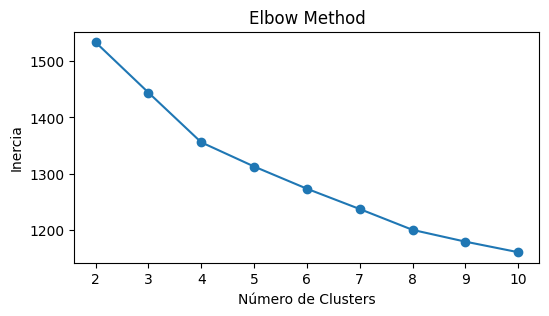

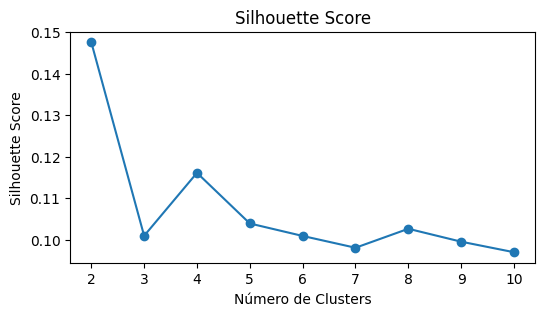

In [111]:
# Calcular la inercia para el método del codo (Elbow method)
inertia = []
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_clusters)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_clusters, kmeans.labels_))

# Graficar Elbow Method
plt.figure(figsize=(6, 3))
plt.plot(range(2, 11), inertia, marker='o', linestyle='-')
plt.title('Elbow Method')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.show()

# Graficar Silhouette Score
plt.figure(figsize=(6, 3))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-')
plt.title('Silhouette Score')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.show()

A partir del gráfico de codo podríamos pensar en hacer 4 clusters u 8 clusters.
<br>
Sin embargo, el gráfico de Silhouette nos dice que el número ideal son 2.
<br><br>
-> Debido a la naturaleza del análisis intentaremos hacer 2 clusters.

In [112]:
# Inicializar el modelo KMeans con 10 iteraciones
kmeans = KMeans(init='random', n_clusters=2, n_init=10)

# Ajustar el modelo a los datos
kmeans.fit(df_clusters)

# Predecir el clúster para cada registro
clusters = kmeans.predict(df_clusters)

Revisamos si los nuevos clusters reflejan el nivel de ansiedad

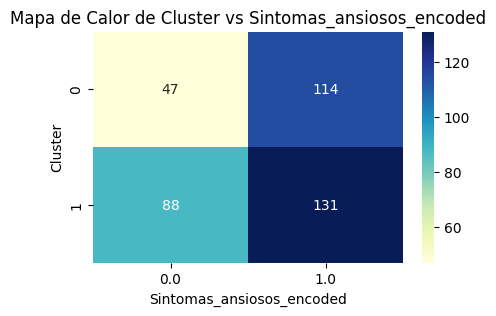

In [113]:
# Combinar las columnas relevantes en un DataFrame
df_combined = pd.DataFrame({
    'cluster': clusters,  # Usamos la variable clusters en lugar de 'cluster'
    'Sintomas_ansiosos_encoded': df_TC_scaled['Sintomas_ansiosos_encoded']
})

# Crear una tabla de contingencia
contingency_table = pd.crosstab(df_combined['cluster'], df_combined['Sintomas_ansiosos_encoded'])

# Graficar el mapa de calor
plt.figure(figsize=(5, 3))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Mapa de Calor de Cluster vs Sintomas_ansiosos_encoded')
plt.xlabel('Sintomas_ansiosos_encoded')
plt.ylabel('Cluster')
plt.show()

In [57]:
# Saco las variables de la tabla de contingencia
TN=contingency_table[0.0][0]
FP=contingency_table[0.0][1]
FN=contingency_table[1.0][0]
TP=contingency_table[1.0][1]

# Calculo métricas
Recall=TP/(TP+FN)
Precision=TP/(TP+FP)
F1=2*((Precision*Recall)/(Precision+Recall))

# Muestro las métricas
print("Recall: %.2f" % (Recall*100))
print("F1: %.2f" % (F1*100))

Recall: 46.53
F1: 56.16


Conclusión K-means:

*   El clúster "0" cuenta con 47 registros con ansiedad leve y 114 registros con ansiedad moderada-alta.
*   El clúster "1" cuenta con 88 registros con ansiedad leve y 131 registros con ansiedad moderada-alta.

Se observa un gran porcentaje de falsos positivos, sin embargo, hay un menor número de falsos negativos, lo cual es algo que se busca en investigaciones médicas. No obstante, el recall sigue siendo bajo.

Dado lo anterior, no podemos decir que los clústeres encontrados agrupan pacientes de acuerdo a su nivel de ansiedad de manera perfecta. Sin embargo, no es necesario desechar totalmente los resultados y podríamos pensar en tratar de mejorar el algoritmo.

De igual manera se planea investigar otros algoritmos de clustering para esta aplicación.

### 3.2 Exploración visual con PCA

Una opción para visualizar mejor los datos y los clusters es graficándolos con un scatterplot, ya sea en 2 o 3 dimensiones. En nuestro caso, usaremos PCA para reducir las dimensiones y poder visualizar mejor los datos

In [114]:
# Configurar para n_components=3
principal=PCA(n_components=3)
principal.fit(df_clusters)
x=principal.transform(df_clusters)

# Revisar las dimensiones
print(x.shape)


(380, 3)


Text(0.5, 0, 'PC3')

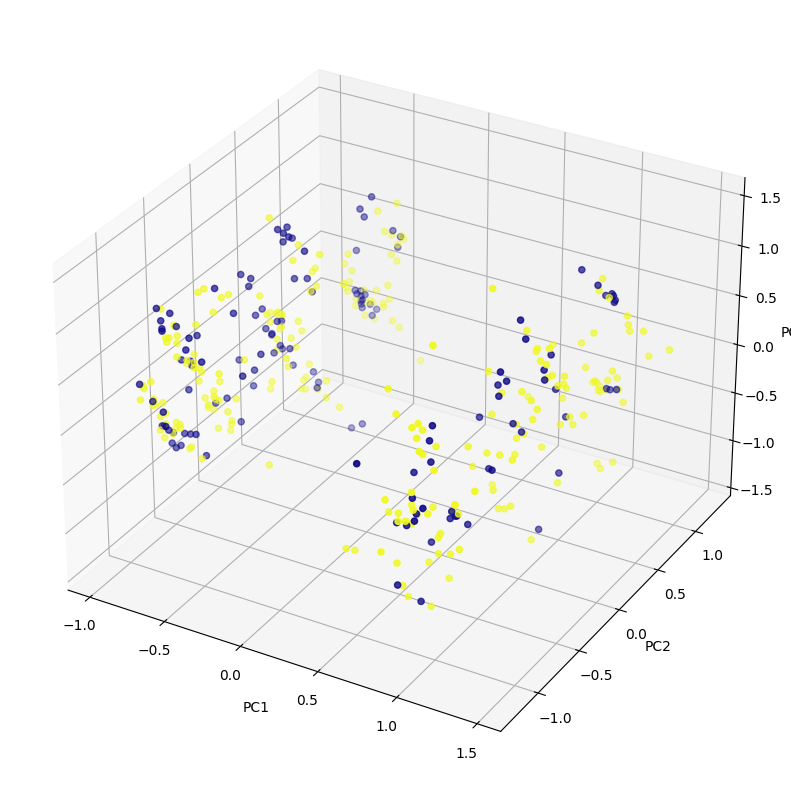

In [115]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))

# Configuramos grafica 3d
axis = fig.add_subplot(111, projection='3d')

# x[:,0]es pc1,x[:,1] es pc2 y x[:,2] es pc3
axis.scatter(x[:,0],x[:,1],x[:,2], c=df_TC_scaled['Sintomas_ansiosos_encoded'],cmap='plasma')
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)
axis.set_zlabel("PC3", fontsize=10)

Ahora podemos visualizar los datos, pero necesitamos revisar si realmente representan la realidad de los datos originales.

In [116]:
print('Variación por cada componente principal: {}'.format(principal.explained_variance_ratio_))
print('Total: {:.1f}'.format(round(principal.explained_variance_ratio_.sum(), 1)))

Variación por cada componente principal: [0.15063613 0.1007083  0.06970526]
Total: 0.3


El componente principal 1 contiene el 15% de la información, el componente segundo contiene el 10%, mientras que el componente principal 3 contiene solo el 6% de la información. En total acumulamos una varianza del 30 % lo cual nos indica que tres componentes de PCA no son suficientes para mantener la información de los datos. La visualización de los clúster no será posible por lo que procederemos a usar otros métodos estadísticos para representarlos.

### 3.3 K-means con 3 o más  clusters

En un caso ideal, esperaríamos que k-means encontrara dos clusters y que cada uno correspondiera a un nivel de ansiedad. Sin embargo, es posible que, agrupando en más de dos clusters, alguno de ellos corresponda con el nivel de ansiedad. El hecho de que el elbow method no mostrara un numero especifico de clúster ideal, contribuye a que hagamos este análisis.

In [117]:
ansiedad_means = df_TC_scaled['Sintomas_ansiosos_encoded'].mean()
print(round(ansiedad_means,2))

0.64


El promedio de la ansiedad en los datos es de 0.64.

Usamos k-means para encontrar desde 2 hasta 8 clústeres. Graficamos la media de la ansiedad de cada clúster.

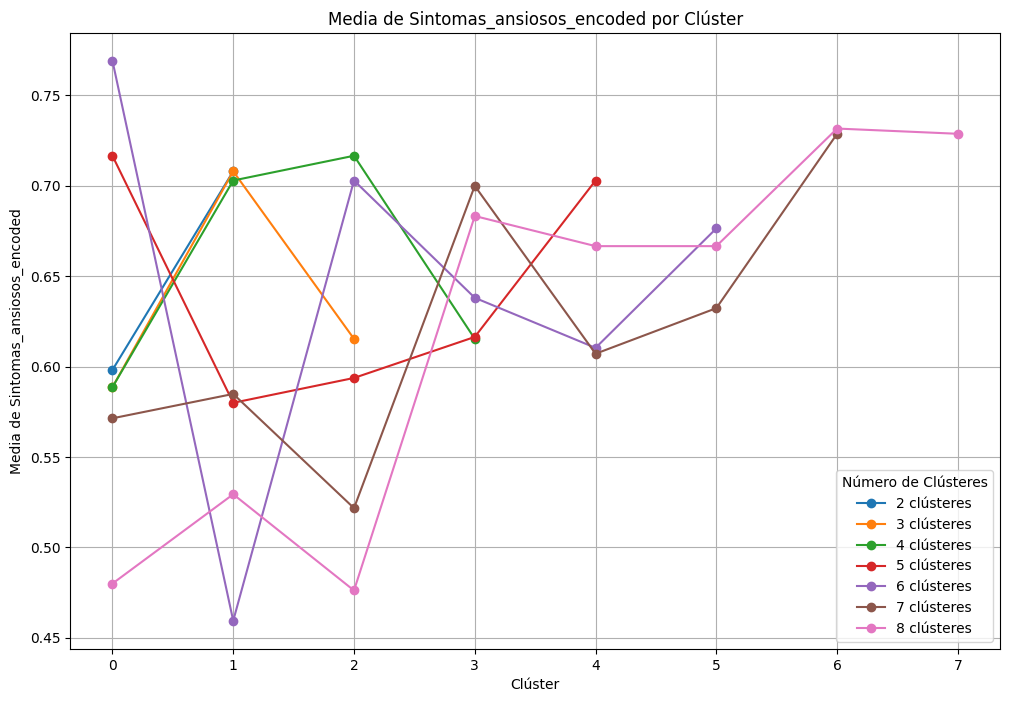

In [118]:
# Definir el rango para el número de clústeres
cluster_range = range(2, 9)

# Lista para almacenar los resultados de las medias
means_list = []

for i in cluster_range:
    # Inicializar el modelo KMeans con el número actual de clústeres
    kmeans = KMeans(init='random', n_clusters=i, n_init=10, random_state = 42)

    # Ajustar el modelo a los datos
    kmeans.fit(df_clusters)

    # Predecir el clúster para cada registro
    clusters = kmeans.predict(df_clusters)

    # Combinar las columnas relevantes en un DataFrame
    df_combined_iter = pd.DataFrame({
        'cluster': clusters,
        'Sintomas_ansiosos_encoded': df_TC_scaled['Sintomas_ansiosos_encoded']
    })

    # Calcular la media de 'Sintomas_ansiosos_encoded' para cada clúster
    cluster_means = df_combined_iter.groupby('cluster')['Sintomas_ansiosos_encoded'].mean()

    # Almacenar las medias en la lista
    means_list.append(cluster_means)

# Graficar las medias
plt.figure(figsize=(12, 8))

for i, cluster_means in enumerate(means_list, start=2):
    plt.plot(cluster_means.index, cluster_means.values, marker='o', label=f'{i} clústeres')

plt.title('Media de Sintomas_ansiosos_encoded por Clúster')
plt.xlabel('Clúster')
plt.ylabel('Media de Sintomas_ansiosos_encoded')
plt.legend(title='Número de Clústeres')
plt.grid(True)
plt.show()


Observamos que agrupando los datos en 6 clústeres, dos de ellos muestran niveles de ansiedad desviados de la media, lo cual puede indicar que esos clústeres están relacionados con la ansiedad:
*   **Media de los datos: 0.64**
*   Media del clúster 0: 0.77
*   Media del clúster 1: 0.47

### 3.3 Hierarchical clustering

Se prueba con usando cuatro métodos diferentes:

*   Single (Enlace sencillo): Distancia mínima entre puntos

*   Complete (Enlace completo): Distancia máxima entre puntos

*   Average (Enlace promedio): Distancia promedio entre todas los objetos

*   Ward: Basada en la suma de cuadrados

In [119]:
# Hacer una copia de df_clusters
df_clusters_hierar = df_clusters.copy()

# Definir los métodos jerárquicos
metodos_jerarquicos = ['single', 'complete', 'average', 'ward']

for metodo in metodos_jerarquicos:
    # Usar la función linkage con el método actual
    matriz_distancia = linkage(df_clusters_hierar, method=metodo, metric="euclidean")

    # Asignar etiquetas de clúster al DataFrame
    clusters = fcluster(matriz_distancia, 2, criterion='maxclust')

    # Agregar etiquetas de clúster al DataFrame
    df_clusters_hierar['etiquetas_cluster_{}'.format(metodo)] = clusters

    # Imprimir los valores únicos de las etiquetas de clúster para el método actual
    print("Etiquetas de clúster para el método {}: \n{}".format(metodo, df_clusters_hierar['etiquetas_cluster_{}'.format(metodo)].value_counts()))



Etiquetas de clúster para el método single: 
etiquetas_cluster_single
1    379
2      1
Name: count, dtype: int64
Etiquetas de clúster para el método complete: 
etiquetas_cluster_complete
2    376
1      4
Name: count, dtype: int64
Etiquetas de clúster para el método average: 
etiquetas_cluster_average
2    378
1      2
Name: count, dtype: int64
Etiquetas de clúster para el método ward: 
etiquetas_cluster_ward
1    220
2    160
Name: count, dtype: int64


Se observa que solamente el método "Ward" encuentra clusters con tamaños comparables.

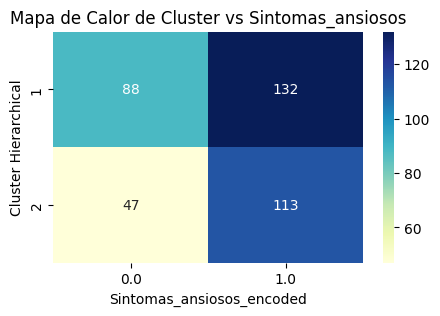

In [120]:
# Eliminamos las etiquetas de los metodos descartados
df_clusters_hierar.drop(columns=['etiquetas_cluster_single', 'etiquetas_cluster_complete', 'etiquetas_cluster_average'], inplace=True)

# Combinar las columnas relevantes en un DataFrame
df_clusters_hierar['Sintomas_ansiosos_encoded'] = df_TC_scaled['Sintomas_ansiosos_encoded']

# Crear una tabla de contingencia
contingency_table = pd.crosstab(df_clusters_hierar['etiquetas_cluster_ward'], df_clusters_hierar['Sintomas_ansiosos_encoded'])

# Graficar el mapa de calor
plt.figure(figsize=(5, 3))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Mapa de Calor de Cluster vs Sintomas_ansiosos')
plt.xlabel('Sintomas_ansiosos_encoded')
plt.ylabel('Cluster Hierarchical')
plt.show()